In [30]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm, trange
try:
  from helpers import get_model_size, estimate_loss, normalize_tensor
except ModuleNotFoundError:
  import sys
  sys.path.append("../")
  from helpers import get_model_size, estimate_loss, normalize_tensor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# we actually just need it to download cifar dataset
torchvision.datasets.CIFAR10(train=True, download=True, root='../data/', transform=transforms.ToTensor())
torchvision.datasets.CIFAR10(train=False, download=True, root='../data/', transform=transforms.ToTensor())

In [4]:
class CiFaData(Dataset):
  def __init__(self, stage="train", transform=None, device="cpu"):
    self.device = device
    self.base_folder = "cifar-10-batches-py"
    self.transform = transform
    if stage == "train":
      batch_collection = [f"data_batch_{i}" for i in range(1, 5)]
    elif stage == "val":
      batch_collection = ["data_batch_5"]
    elif stage == "test":
      batch_collection = ["test_batch"]
    else:
      raise ValueError("Invalid stage, choose from train, val, test.")
    self.x_data = []
    self.y_data = []
    for batch in batch_collection:
      with open(f"../data/cifar-10-batches-py/{batch}", "rb") as f:
        data = pickle.load(f, encoding="latin1") 
        self.x_data.extend(data["data"])
        self.y_data.extend(data["labels"])
    self.y_data = torch.tensor(self.y_data, device=self.device)
    self.x_data = normalize_tensor(torch.tensor(np.vstack(self.x_data).reshape(-1, 3, 32, 32), device=self.device)) # from list to vstack; results in (N, 3, 32, 32)
  def __len__(self):
    return len(self.y_data)
  def __getitem__(self, idx):
    if self.transform:
      return self.transform(self.x_data[idx]), self.y_data[idx]
    return self.x_data[idx], self.y_data[idx]

In [5]:
tf = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_ds = CiFaData(stage="train", device=device)
val_ds = CiFaData(stage="val", device=device)
test_ds = CiFaData(stage="test", device=device)

In [61]:
# pinning memory, takes cpu data and pins it to the gpu. meaning if I already 
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True) 
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False)

In [51]:
# using the Sequential container - looks a bit cleaner
class LittleConv(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
    nn.Conv2d(3,6,5), # out: (B, 6, 28, 28)
    nn.ReLU(),
    nn.MaxPool2d(2,2), # (B, 6, 14, 14)
    nn.Flatten(1),
    nn.Linear(6 *14*14, 10) # (B, 10)
    )
  def forward(self, x):
    return self.net(x)

In [ ]:
# with cuda: bs32 - 2.44s; bs64 - 2.47; bs128 - 2.31s

epochs = 20

littleconv = LittleConv()
optimimizer = optim.SGD(lr=0.001, params=littleconv.parameters(), momentum=0.9)
criterion = nn.CrossEntropyLoss()
littleconv.to('cuda')

for i in (t:= trange(epochs)):
  for x, y in train_loader:
    optimimizer.zero_grad()
    pred = littleconv(x)  
    loss = criterion(pred, y)
    loss.backward()
    optimimizer.step()

  t.set_description(f"epoch {i+1}: loss: {loss.item():.4f}")
f"that took {t.format_interval(t.format_dict['elapsed'])} minutes"

ResNet 18

In [55]:
class SubBlock(nn.Module):
  def __init__(self, inchannels, outchannels, stride, kernelsize=3, padding=1):
    super().__init__()
    self.block = nn.Sequential(
      nn.Conv2d(in_channels=inchannels, out_channels=outchannels, kernel_size=kernelsize, padding=padding, stride=stride),
      nn.BatchNorm2d(outchannels),
      nn.ReLU(),
      nn.Conv2d(in_channels=outchannels, out_channels=outchannels, kernel_size=kernelsize, padding=padding, stride=1),
      nn.BatchNorm2d(outchannels)
    )
  def forward(self, x):
    return self.block(x)

In [56]:
class ResBlock(nn.Module):
  def __init__(self, inchannels, outchannels, stride):
    super().__init__()
    self.block = nn.Sequential(
      SubBlock(inchannels, outchannels, stride),
      SubBlock(outchannels, outchannels, stride=1)
    )
  def forward(self, x):
    return self.block(x)

In [43]:
# from the paper
# We adopt batch normalization (BN) [16] right after each convolution and
# before activation, following [16].

In [62]:
class ResNet18(nn.Module):
  def __init__(self):
    super().__init__()
    self.block0 = nn.Sequential(
      nn.Conv2d(in_channels=3, kernel_size=7, out_channels=64, stride=2, padding=3), 
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    )
    self.block1 = ResBlock(64, 64, stride=1)
    self.relu1 = nn.ReLU() 
    self.match_dim2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1, stride=2)
    self.block2 = ResBlock(64,128, stride=2)
    self.relu2 = nn.ReLU()
    self.match_dim3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=1, stride=2)
    self.block3 = ResBlock(128, 256, stride=2)
    self.relu3 = nn.ReLU()
    self.match_dim4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=1, stride=2)
    self.block4 = ResBlock(256, 512, stride=2)
    self.relu4 = nn.ReLU()
    self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(512, 10)
  def forward(self, x):
    # ---------- Block0 ---------- 
    x = self.block0(x)
    # ---------- Block1 ---------- 
    x_skip = x
    x = self.block1(x)
    x = self.relu1(x+x_skip)
    # ---------- Block2 ---------- 
    x_skip = self.match_dim2(x)
    x = self.block2(x)
    x = self.relu2(x+x_skip)
    # ---------- Block3 ---------- 
    x_skip = self.match_dim3(x)
    x = self.block3(x)
    x = self.relu3(x+x_skip)
    # ---------- Block4 ---------- 
    x_skip = self.match_dim4(x)
    x = self.block4(x)
    x = self.relu4(x+x_skip)
    # ---------- Linear ----------
    x = self.avg_pool(x)
    x = torch.flatten(x, start_dim=1)
    return self.fc(x)

In [58]:
# currently: 4.01s/it
# after custom normalize: 2.04
# modular definition: 1.89, yay. but model size increased from 41.97 to 42.63 MB. speed stays the same if I pull relu inside init.
# adding batchnorm layers makes it way slower again: 2.33s/it

In [65]:
epochs = 2000
lr = 3e-4
res18 = ResNet18()
res18.to(device)

# optimizer = optim.SGD(params=[p for p in res18.parameters() if p.requires_grad == True], momentum=0.9, lr=0.05)
optimizer = optim.AdamW(params=[p for p in res18.parameters() if p.requires_grad==True], lr=lr)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', patience=2)
criterion = nn.CrossEntropyLoss()

model_size = get_model_size(res18)

model size: 42.696 MB


# todos:
## add a good scheduler, check if batchnorm is properly applied
## hyperparameter tuning
## increase size: make a resnet 50
## extract feature detection layers
##

In [66]:
# training loop
losses = []
raw_losses = []
val_losses = []

for i in (t:=trange(epochs)):
  epoch_loss = []
  for step, (x, y) in enumerate(train_loader):
    predictions = res18(x)
    loss = criterion(predictions, y)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    raw_losses.append(loss.item())
    epoch_loss.append(loss.item())

  # only one per iteration
  losses.append(np.mean(epoch_loss))
  val_losses.append(estimate_loss(res18, val_loader, criterion))
  scheduler.step(metrics=val_losses[-1])
  t.set_description(f"epoch {i+1} | training loss: {losses[-1]:.4f} | validation loss: {val_losses[-1]:.4f} | current lr: {optimizer.param_groups[0]['lr']:.4f}")
  
test_loss = estimate_loss(res18, test_loader, criterion) 
print(f'final test loss is : {test_loss}')


  0%|          | 0/2000 [00:00<?, ?it/s]

epoch 20 | training loss: 0.0157 | validation loss: 1.1882 | current lr: 0.0000:   1%|          | 20/2000 [00:31<50:49,  1.54s/it]

In [ ]:
plt.figure()
plt.title(f'batchnorm  lr={lr}')
plt.plot(range(epochs), losses, label='training')
plt.plot(range(epochs), val_losses, label='validation')
plt.plot(range(epochs), [np.min(val_losses)]*epochs, color='r', label=f'minimum val loss at epoch {np.argmin(val_losses)+1}')
plt.plot(range(epochs), [test_loss]*epochs, linestyle='dashed', label='test loss')
plt.legend()
plt.show()

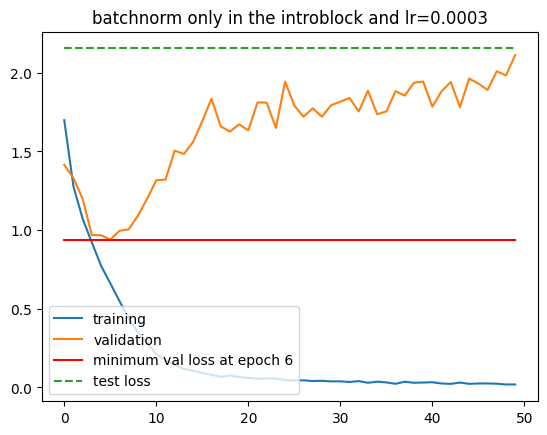

In [54]:
plt.figure()
plt.title(f'batchnorm only in the introblock and lr={lr}')
plt.plot(range(epochs), losses, label='training')
plt.plot(range(epochs), val_losses, label='validation')
plt.plot(range(epochs), [np.min(val_losses)]*epochs, color='r', label=f'minimum val loss at epoch {np.argmin(val_losses)+1}')
plt.plot(range(epochs), [test_loss]*epochs, linestyle='dashed', label='test loss')
plt.legend()
plt.show()

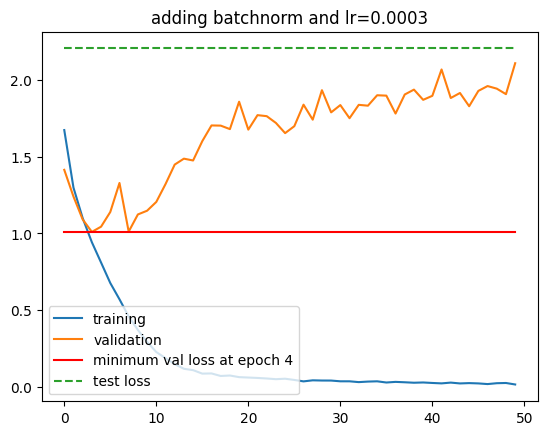

In [47]:
# better, but still seems to diverge beginning in about epoch 30 or so
plt.figure()
plt.title(f'adding batchnorm and lr={lr}')
plt.plot(range(epochs), losses, label='training')
plt.plot(range(epochs), val_losses, label='validation')
plt.plot(range(epochs), [np.min(val_losses)]*epochs, color='r', label=f'minimum val loss at epoch {np.argmin(val_losses)+1}')
plt.plot(range(epochs), [test_loss]*epochs, linestyle='dashed', label='test loss')
plt.legend()
plt.show()

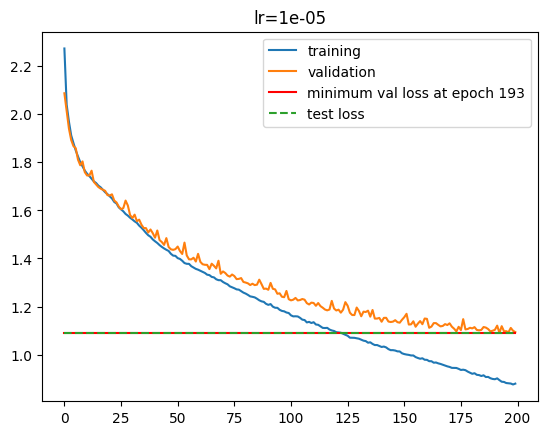

In [66]:
# better, but still seems to diverge beginning in about epoch 30 or so
plt.figure()
plt.title(f'lr={lr}')
plt.plot(range(epochs), losses, label='training')
plt.plot(range(epochs), val_losses, label='validation')
plt.plot(range(epochs), [np.min(val_losses)]*epochs, color='r', label=f'minimum val loss at epoch {np.argmin(val_losses)+1}')
plt.plot(range(epochs), [test_loss]*epochs, linestyle='dashed', label='test loss')
plt.legend()
plt.show()

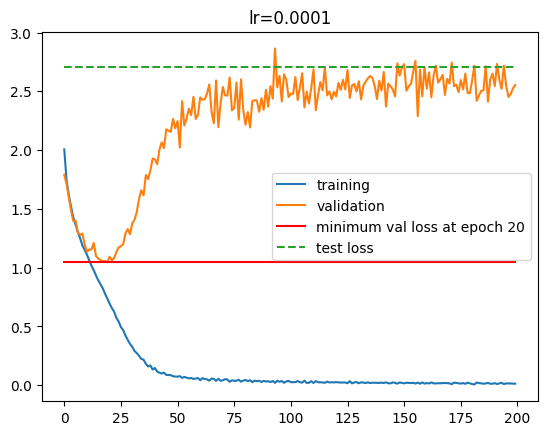

In [63]:
# we can either adapt the learning rate at about 25 or make it way smaller
plt.figure()
plt.title(f'lr={lr}')
plt.plot(range(epochs), losses, label='training')
plt.plot(range(epochs), val_losses, label='validation')
plt.plot(range(epochs), [np.min(val_losses)]*epochs, color='r', label=f'minimum val loss at epoch {np.argmin(val_losses)+1}')
plt.plot(range(epochs), [test_loss]*epochs, linestyle='dashed', label='test loss')
plt.legend()
plt.show()

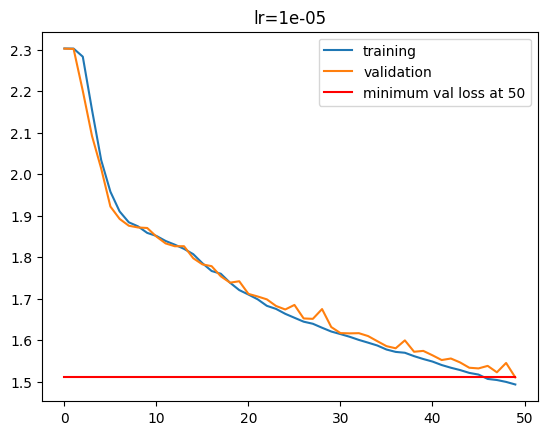

In [27]:
plt.figure()
plt.title(f'lr={lr}')
plt.plot(range(epochs), losses, label='training')
plt.plot(range(epochs), val_losses, label='validation')
plt.plot(range(epochs), [np.min(val_losses)]*epochs, color='r', label=f'minimum val loss at epoch {np.argmin(val_losses)+1}')
plt.legend()
plt.show()

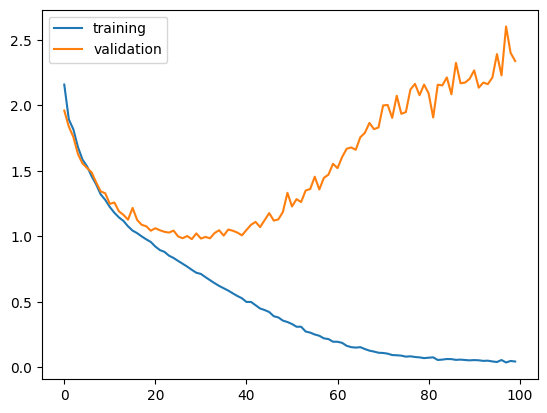

In [13]:
plt.figure()
plt.title('lr=0.0001')
plt.plot(range(epochs), losses, label='training')
plt.plot(range(epochs), val_losses, label='validation')
plt.plot(range(epochs), np.min(val_losses))
plt.legend()
plt.show()